In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import yaml
import scipy as sp
import scipy.stats as sp_stats
import math
import tqdm.auto as tqdm

from functional import seq
from pathlib import Path
from typing import Tuple, List
from matplotlib import cm


pd.options.display.float_format = '{:.4f}'.format
plt.rcParams.update({
    "text.usetex": True,
})

NUM_FEATURES_PER_DATASET = {
    "cluto": 2,
    "complex9": 2,
    "letter": 16
}

In [2]:
files = list(Path("../experiments/").rglob("STAT"))
len(files)
metrics_columns = ["Purity", "RAND", "Silhouette", "Davis-Bouldin", "\#Multi Borders"]

In [3]:
def get_class_assignments(file_path: Path) -> List[List[int]]:
    data = file_path.read_text().split("\n")
    dataset = file.parent.name.split("_")[0]
    dataset = dataset if "cluto" not in dataset else "cluto"
    output = []
    for line in data:
        if len(line) == 0:
            continue
        components = line.split(",")
        class_assignments = seq(components[3 + NUM_FEATURES_PER_DATASET[dataset]:]).map(int).list()
        output.append(class_assignments)
    return output

def get_num_border_points_with_multiple_assignments(path: Path) -> int:
    return seq(get_class_assignments(path)).filter(lambda x: len(x) > 1).map(len).sum()

In [4]:
data = []
for file in tqdm.tqdm(files):
    if "sanity_experiment" in file.parent.name or "final" in file.parent.name or "realdata" in file.parent.name or "zpndata" in file.parent.name:
        continue
    with open(file) as f:
        dataset, eps, min_pts, algo, _, filtering = file.parent.name.split("_")
        
        sample = yaml.safe_load(f.read().replace("\t", ""))
        if "-model_fitting" in sample:
            sample.update({
                "dataset": dataset if "cluto" not in dataset else "cluto",
                "algorithm": algo,
                "filtering": filtering,
                "model_fitting": sample["-model_fitting"],
                "data_reading": sample["-data_reading"],
                "davis_bouldin": float(sample["davis_bouldin"]),
            })
        else:
            sample.update({
                "dataset": dataset if "cluto" not in dataset else "cluto",
                "algorithm": algo,
                "filtering": filtering,
                "model_fitting": sample["-clustering"],
                "data_reading": sample["-data_reading"],
                "sorting": sample["-sorting"],
                "davis_bouldin": float(sample["davis_bouldin"]),
            })
        
        class_assignments = get_class_assignments(file.parent / "OUT")
        total_border_points = seq(class_assignments).filter(lambda x: len(x) > 1).map(len).sum()
        
        sample["\#Multi Borders"] = total_border_points
        
        
        del sample["-data_reading"]
        
        if "-clustering" in sample:
            del sample["-sorting"]
            del sample["-clustering"]
        else:
            del sample["-model_fitting"]
        
        del sample["runtimes_miliseconds"]
        del sample["input_file"]
        data.append(sample)
        
        
frame = pd.DataFrame(data)
frame = frame.rename(
    columns={
        'purity': 'Purity',
        "davis_bouldin": "Davis-Bouldin",
        "rand": "RAND",
        "silhouette": "Silhouette"
    }
)
frame = frame.fillna(0)

In [5]:
frame.columns

Index(['Eps', 'minPts', 'total_runtime_miliseconds', 'num_discovered_clusters',
       'nun_discovered_core_points', 'nun_discovered_border_points',
       'num_discovered_noise_points', 'avg_num_calculations_of_similarity',
       'avg_num_cluster_assignments', 'num_true_positives',
       'num_true_negatives', 'Purity', 'RAND', 'Silhouette', 'Davis-Bouldin',
       'dataset', 'algorithm', 'filtering', 'model_fitting', 'data_reading',
       '\#Multi Borders', 'sorting'],
      dtype='object')

### Epsilon, cluto

In [6]:
def print_eps_for_dataset(dataset):
    data = frame[
        (frame["filtering"] == "none")
        & (frame["minPts"] == 5)
        & (frame["dataset"] == dataset)
    ]
    data = pd.merge(
        data[data["algorithm"] == "base"], 
        data[data["algorithm"] == "tanimoto"],
        on="Eps",
        suffixes=["_base", "_tanimoto"]
    )
    data = data.sort_values(by="Eps")[
        ["Eps"] + seq(
            [[m + "_base", m + "_tanimoto"] for m in metrics_columns]
        ).flatten().list()
    ]
    max_values = data.max()
    min_values = data.min()
    for column in data.columns:
        data[column] = data[column].apply(
            lambda x: "\textbf{{{:.4f}}}".format(x) if x == (max_values[column] if "Davis-Bouldin" not in column else min_values[column]) else "{:.4f}".format(x)
        )
    print(data.to_latex(escape=False, index=False))
print_eps_for_dataset("cluto")

\begin{tabular}{lllllllllll}
\toprule
            Eps &     Purity_base & Purity_tanimoto &       RAND_base &   RAND_tanimoto & Silhouette_base & Silhouette_tanimoto & Davis-Bouldin_base & Davis-Bouldin_tanimoto & \#Multi Borders_base & \#Multi Borders_tanimoto \\
\midrule
         0.0001 & \textbf{0.2758} &          0.2758 & \textbf{0.1634} &          0.1634 & \textbf{0.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
         0.0010 & \textbf{0.2758} &          0.2758 & \textbf{0.1634} &          0.1634 & \textbf{0.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
         0.0100 & \textbf{0.2758} &          0.2758 & \textbf{0.1634} &          0.1634 & \textbf{0.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
         0.0500 & \textbf{0.2758} &          

### Epsilon, complex9

In [7]:
print_eps_for_dataset("complex9")

\begin{tabular}{lllllllllll}
\toprule
            Eps &     Purity_base & Purity_tanimoto &       RAND_base &   RAND_tanimoto & Silhouette_base & Silhouette_tanimoto & Davis-Bouldin_base & Davis-Bouldin_tanimoto & \#Multi Borders_base & \#Multi Borders_tanimoto \\
\midrule
         0.0001 & \textbf{0.2989} &          0.2989 & \textbf{0.1859} &          0.1859 & \textbf{0.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
         0.0010 & \textbf{0.2989} &          0.2989 & \textbf{0.1859} &          0.1859 & \textbf{0.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
         0.0100 & \textbf{0.2989} &          0.2989 & \textbf{0.1859} &          0.1859 & \textbf{0.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
         0.0500 & \textbf{0.2989} &          

### Epsilon, letter

In [8]:
print_eps_for_dataset("letter")

\begin{tabular}{lllllllllll}
\toprule
            Eps &     Purity_base & Purity_tanimoto &       RAND_base &   RAND_tanimoto & Silhouette_base & Silhouette_tanimoto & Davis-Bouldin_base & Davis-Bouldin_tanimoto & \#Multi Borders_base & \#Multi Borders_tanimoto \\
\midrule
         0.0001 &          0.0575 &          0.0406 &          0.0699 &          0.0384 & \textbf{1.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &                  0.0 &                      0.0 \\
         0.0010 &          0.0575 &          0.0406 &          0.0699 &          0.0384 & \textbf{1.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &                  0.0 &                      0.0 \\
         0.0100 &          0.0575 &          0.0406 &          0.0699 &          0.0384 & \textbf{1.0000} &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &                  0.0 &                      0.0 \\
         0.0500 &          0.0575 &          

### Min pts, cluto

In [9]:
def print_min_pts_for_dataset(dataset):
    data = frame[
        (frame["filtering"] == "none")
        & (
            (
                (frame["Eps"] == 0.1) & (frame["algorithm"] == "base")
                | (frame["Eps"] == 0.99) & (frame["algorithm"] == "tanimoto")
            )
        )
        & (frame["dataset"] == dataset)
    ]
    data = pd.merge(
        data[data["algorithm"] == "base"], 
        data[data["algorithm"] == "tanimoto"],
        on="minPts",
        suffixes=["_base", "_tanimoto"]
    )
    data = data.sort_values(by="minPts")[
        ["minPts"] + seq(
            [[m + "_base", m + "_tanimoto"] for m in metrics_columns]
        ).flatten().list()
    ]
    max_values = data.max()
    min_values = data.min()
    print(len(data))
    for column in data.columns:
        data[column] = data[column].apply(
            lambda x: "\textbf{{{:.4f}}}".format(x) if x == (max_values[column] if "Davis-Bouldin" not in column else min_values[column]) else "{:.4f}".format(x)
        )
    print(data.to_latex(escape=False, index=False))
print_min_pts_for_dataset("cluto")

7
\begin{tabular}{lllllllllll}
\toprule
           minPts &     Purity_base & Purity_tanimoto &       RAND_base &   RAND_tanimoto & Silhouette_base & Silhouette_tanimoto & Davis-Bouldin_base & Davis-Bouldin_tanimoto & \#Multi Borders_base & \#Multi Borders_tanimoto \\
\midrule
              0.0 & \textbf{1.0000} &          0.2776 & \textbf{0.8366} &          0.1664 & \textbf{0.9999} &              0.0909 &             0.0005 &                 0.3333 &      \textbf{0.0000} &                      0.0 \\
              1.0 & \textbf{1.0000} &          0.2776 & \textbf{0.8366} &          0.1664 & \textbf{0.9999} &              0.0909 &             0.0005 &                 0.3333 &      \textbf{0.0000} &                      0.0 \\
              5.0 &          0.2758 &          0.2784 &          0.1634 &          0.1678 &             0.0 &              0.0000 &    \textbf{0.0000} &        \textbf{0.0000} &      \textbf{0.0000} &                      0.0 \\
             10.0 &          0.2758

### Min pts, complex9

In [10]:
print_min_pts_for_dataset("complex9")

7
\begin{tabular}{lllllllllll}
\toprule
           minPts &     Purity_base & Purity_tanimoto &       RAND_base &   RAND_tanimoto & Silhouette_base & Silhouette_tanimoto & Davis-Bouldin_base & Davis-Bouldin_tanimoto & \#Multi Borders_base & \#Multi Borders_tanimoto \\
\midrule
              0.0 & \textbf{1.0000} &          0.4127 & \textbf{0.8141} &          0.5307 & \textbf{0.9999} &              0.1756 &             0.0001 &                 0.4812 &      \textbf{0.0000} &                      0.0 \\
              1.0 & \textbf{1.0000} &          0.4127 & \textbf{0.8141} &          0.5307 & \textbf{0.9999} &              0.1756 &             0.0001 &                 0.4812 &      \textbf{0.0000} &                      0.0 \\
              5.0 &          0.2989 &          0.4131 &          0.1859 &          0.5307 &             0.0 &              0.2934 &    \textbf{0.0000} &                 0.4916 &      \textbf{0.0000} &                      0.0 \\
             10.0 &          0.2989

### Min pts, letter

In [11]:
print_min_pts_for_dataset("letter")

7
\begin{tabular}{lllllllllll}
\toprule
           minPts &     Purity_base & Purity_tanimoto &       RAND_base &   RAND_tanimoto & Silhouette_base & Silhouette_tanimoto & Davis-Bouldin_base & Davis-Bouldin_tanimoto & \#Multi Borders_base & \#Multi Borders_tanimoto \\
\midrule
              0.0 & \textbf{1.0000} & \textbf{0.6389} & \textbf{0.9616} & \textbf{0.9113} & \textbf{1.0000} &             -0.1171 &                0.0 &                 0.5469 &      \textbf{0.0000} &                      0.0 \\
              1.0 & \textbf{1.0000} & \textbf{0.6389} & \textbf{0.9616} & \textbf{0.9113} & \textbf{1.0000} &             -0.1171 &                0.0 &                 0.5469 &      \textbf{0.0000} &                      0.0 \\
              5.0 &          0.0575 &          0.4637 &          0.0699 &          0.8787 & \textbf{1.0000} &              0.2262 &                0.0 &                 0.9390 &      \textbf{0.0000} &        \textbf{156.0000} \\
             10.0 &          0.0443

### Avg calculations for epsilon

In [12]:
def print_avg_num_calculations_for_datasets_for_epsilon():
    data = frame[
        (frame["algorithm"] == "tanimoto")
        & (frame["minPts"] == 5)
    ][["avg_num_calculations_of_similarity", "filtering", "dataset", "Eps"]]
    
    datasets = ["cluto", "complex9", "letter"]
    filtering = ["none", "real", "zpn"]
    out = None
    for d in datasets:
        for f in filtering:
            snippet = data[(data["filtering"] == f) & (data["dataset"] == d)][["Eps", "avg_num_calculations_of_similarity"]]
            snippet = snippet.rename(columns={
                "avg_num_calculations_of_similarity": "avg_{}_{}".format(f, d)
            })
            if out is None:
                out = snippet
                
                print(out.columns)
            else:
                out = pd.merge(
                    out,
                    snippet,
                    on="Eps"
                )
    data = out
    data = data.sort_values(by="Eps")[
        ["Eps"] + [
            "avg_{}_{}".format(f, d) for d in datasets for f in filtering
        ]
    ]
    min_values = data.min()
    print(len(data))
    for column in data.columns[1:]:
        data[column] = data[column].apply(
            lambda x: "\textbf{{{:d}}}".format(int(x)) if (x == min_values[column] and "none" not in column) else "{:d}".format(int(x))
        )
    print(data.to_latex(escape=False, index=False))
print_avg_num_calculations_for_datasets_for_epsilon()

Index(['Eps', 'avg_none_cluto'], dtype='object')
28
\begin{tabular}{rlllllllll}
\toprule
   Eps & avg_none_cluto & avg_real_cluto & avg_zpn_cluto & avg_none_complex9 & avg_real_complex9 & avg_zpn_complex9 & avg_none_letter & avg_real_letter & avg_zpn_letter \\
\midrule
0.0001 &          10000 &           9999 &          7027 &              3031 &              3030 &             1522 &           20000 &           19999 &          19999 \\
0.0010 &          10000 &           9999 &          7027 &              3031 &              3030 &             1522 &           20000 &           19999 &          19999 \\
0.0100 &          10000 &           9999 &          7027 &              3031 &              3030 &             1522 &           20000 &           19999 &          19999 \\
0.0500 &          10000 &           9998 &          7027 &              3031 &              3030 &             1522 &           20000 &           19999 &          19999 \\
0.1000 &          10000 &           9992 &

### Avg time for epsilon

In [13]:
def print_time_for_datasets_for_epsilon():
    data = frame[
        (frame["algorithm"] == "tanimoto")
        & (frame["minPts"] == 5)
    ][["model_fitting", "filtering", "dataset", "Eps"]]
    
    datasets = ["cluto", "complex9", "letter"]
    filtering = ["none", "real", "zpn"]
    out = None
    for d in datasets:
        for f in filtering:
            snippet = data[(data["filtering"] == f) & (data["dataset"] == d)][["Eps", "model_fitting"]]
            snippet = snippet.rename(columns={
                "model_fitting": "time_{}_{}".format(f, d)
            })
            if out is None:
                out = snippet
                
                print(out.columns)
            else:
                out = pd.merge(
                    out,
                    snippet,
                    on="Eps"
                )
    data = out
    data = data.sort_values(by="Eps")[
        ["Eps"] + [
            "time_{}_{}".format(f, d) for d in datasets for f in filtering
        ]
    ]
    min_values = data.min()
    print(len(data))
    for column in data.columns[1:]:
        data[column] = data[column].apply(
            lambda x: "\textbf{{{:d}}}".format(int(x)) if (x == min_values[column] and "none" not in column) else "{:d}".format(int(x))
        )
    print(data.to_latex(escape=False, index=False))
print_time_for_datasets_for_epsilon()

Index(['Eps', 'time_none_cluto'], dtype='object')
28
\begin{tabular}{rlllllllll}
\toprule
   Eps & time_none_cluto & time_real_cluto & time_zpn_cluto & time_none_complex9 & time_real_complex9 & time_zpn_complex9 & time_none_letter & time_real_letter & time_zpn_letter \\
\midrule
0.0001 &           10837 &           10964 &           6989 &                858 &                881 &               426 &            73128 &            76309 &           72484 \\
0.0010 &           11570 &           11241 &           7043 &                845 &                893 &               416 &            74109 &            75159 &           71809 \\
0.0100 &           10425 &           10518 &           6816 &                845 &                873 &               431 &            69350 &            71479 &           68305 \\
0.0500 &           10380 &           10702 &           6772 &                823 &                852 &               407 &            69659 &            70431 &           68038

### Time correlations

In [14]:
def print_time_correlations():
    data = frame[
        (frame["algorithm"] == "tanimoto")
        & (frame["minPts"] == 5)
    ][["model_fitting", "filtering", "dataset", "Eps"]]
    
    datasets = ["cluto", "complex9", "letter"]
    filtering = ["none", "real", "zpn"]
    out = None
    for d in datasets:
        for f in filtering:
            snippet = data[(data["filtering"] == f) & (data["dataset"] == d)][["Eps", "model_fitting"]]
            snippet = snippet.rename(columns={
                "model_fitting": "time_{}_{}".format(f, d)
            })
            if out is None:
                out = snippet
            else:
                out = pd.merge(
                    out,
                    snippet,
                    on="Eps"
                )
    data = out
    data = data.sort_values(by="Eps")[
        ["Eps"] + [
            "time_{}_{}".format(f, d) for d in datasets for f in filtering
        ]
    ]
    times_data = data 
    
    data = frame[
        (frame["algorithm"] == "tanimoto")
        & (frame["minPts"] == 5)
    ][["avg_num_calculations_of_similarity", "filtering", "dataset", "Eps"]]
    
    datasets = ["cluto", "complex9", "letter"]
    filtering = ["none", "real", "zpn"]
    out = None
    for d in datasets:
        for f in filtering:
            snippet = data[(data["filtering"] == f) & (data["dataset"] == d)][["Eps", "avg_num_calculations_of_similarity"]]
            snippet = snippet.rename(columns={
                "avg_num_calculations_of_similarity": "avg_{}_{}".format(f, d)
            })
            if out is None:
                out = snippet
            else:
                out = pd.merge(
                    out,
                    snippet,
                    on="Eps"
                )
    data = out
    data = data.sort_values(by="Eps")[
        ["Eps"] + [
            "avg_{}_{}".format(f, d) for d in datasets for f in filtering
        ]
    ]
    
    correlations_data = data
    output_data = {}
    for column_a, column_b in zip(times_data.columns[1:], correlations_data.columns[1:]):
        print(column_a, column_b)
        correlation = sp_stats.pearsonr(times_data[column_a], correlations_data[column_b])[0]
        output_data["_".join(column_a.split("_")[1:])] = ["{0:.4f}".format(correlation)]
    print(output_data)
    output_data = pd.DataFrame(data=output_data)
    print(output_data.to_latex(escape=False, index=False))
    
print_time_correlations()

time_none_cluto avg_none_cluto
time_real_cluto avg_real_cluto
time_zpn_cluto avg_zpn_cluto
time_none_complex9 avg_none_complex9
time_real_complex9 avg_real_complex9
time_zpn_complex9 avg_zpn_complex9
time_none_letter avg_none_letter
time_real_letter avg_real_letter
time_zpn_letter avg_zpn_letter
{'none_cluto': ['nan'], 'real_cluto': ['0.9988'], 'zpn_cluto': ['0.9944'], 'none_complex9': ['nan'], 'real_complex9': ['0.9973'], 'zpn_complex9': ['0.8067'], 'none_letter': ['nan'], 'real_letter': ['0.9816'], 'zpn_letter': ['0.9921']}
\begin{tabular}{lllllllll}
\toprule
none_cluto & real_cluto & zpn_cluto & none_complex9 & real_complex9 & zpn_complex9 & none_letter & real_letter & zpn_letter \\
\midrule
       nan &     0.9988 &    0.9944 &           nan &        0.9973 &       0.8067 &         nan &      0.9816 &     0.9921 \\
\bottomrule
\end{tabular}



/home/kkania/miniconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


### Real vec len

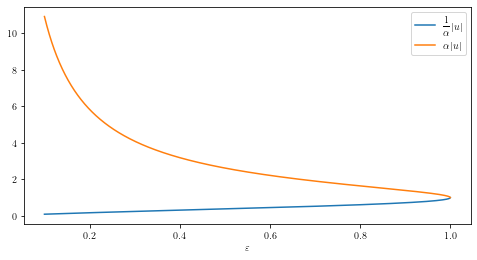

In [15]:
length = 1
fun = lambda x: 0.5 * ((1 + 1 / x) + np.sqrt((1 + 1 / x) ** 2 - 4))
x = np.linspace(0.1, 1.0, num=1000)
fig = plt.figure(figsize=(8, 4))
plt.plot(x, 1 / fun(x) * length, label=r"$$\frac{1}{\alpha}|u|$$")
plt.plot(x, fun(x) * length, label=r"$$\alpha|u|$$")
plt.xlabel(r"$\varepsilon$")
plt.legend()

fig.savefig("../experiments/realveclen.pdf", bbox_inches='tight')

### ZPN vec len

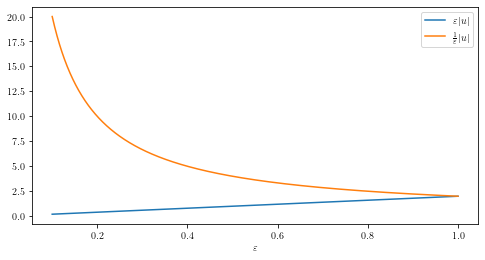

In [16]:
length = 2
fun = lambda x: x
x = np.linspace(0.1, 1.0, num=1000)
fig = plt.figure(figsize=(8, 4))
plt.plot(x, fun(x) * length, label=r"$\varepsilon |u|$")
plt.plot(x, 1 / fun(x) * length, label=r"$\frac{1}{\varepsilon} |u|$")
plt.xlabel(r"$\varepsilon$")
plt.legend()

fig.savefig("../experiments/zpnveclen.pdf", bbox_inches='tight')

In [17]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

Num multiple border points: 16


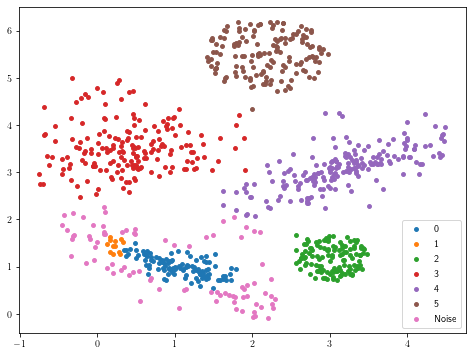

In [40]:
BORDER_POINT = "Border"
NOISE_POINT = "Noise"
MULTIPLE_CLUSTERS = "Multiple Clusters"


def read_data(path: str) -> Tuple[np.ndarray, np.ndarray]:
    with open(path) as f:
        lines = [line for line in f.read().split("\n") if len(line) > 0]
    coords = []
    labels = []
    for line in lines:
        components = line.split(",")
        x, y = float(components[1]), float(components[2])
        point_type = int(components[4])
        assignments = components[5:]
        if point_type == -1:
            labels.append(NOISE_POINT)
#         elif point_type == 0 and len(assignments) > 1:
#             labels.append(MULTIPLE_CLUSTERS)
#         elif point_type == 0 and len(assignments) == 1:
#             labels.append(BORDER_POINT)
        else:
            labels.append(str(assignments[-1]))

        coords.append((x, y))

    return np.array(coords), np.array(labels)


def visualize(path: str, legend=True):
    x, y = read_data(path)
    colormap = cm.get_cmap("tab10")
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    print("Num multiple border points: {}".format(get_num_border_points_with_multiple_assignments(Path(path))))
    
    for label in natural_sort(np.unique(y)):
        ix = np.where(y == str(label))[0]
        ax.scatter(x[ix, 0], x[ix, 1], s=15, label=label, cmap=colormap)
    if legend:
        ax.legend()
    return fig

fig = visualize("../experiments/sanity_experiment_tanimoto/OUT")
fig.savefig("../experiments/sanity_tanimoto.pdf", bbox_inches='tight')

Num multiple border points: 6


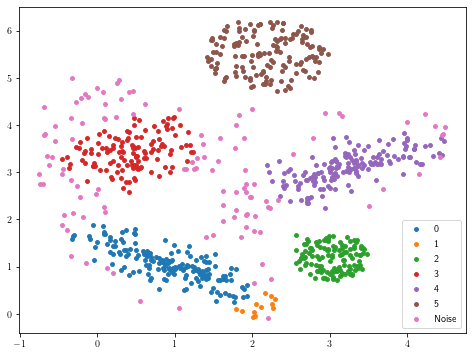

In [41]:
fig = visualize("../experiments/sanity_experiment_base/OUT")
fig.savefig("../experiments/sanity_base.pdf", bbox_inches='tight')

Num multiple border points: 0


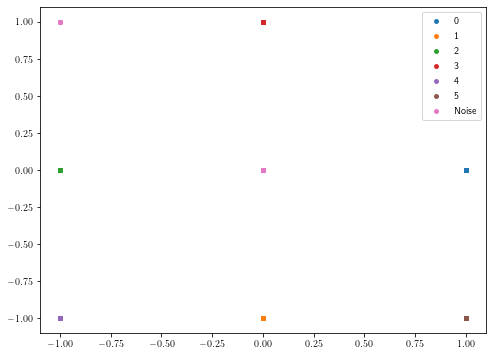

In [42]:
fig = visualize("../experiments/sanity_experiment_tanimoto_zpn/OUT")
fig.savefig("../experiments/sanity_tanimoto_zpn.pdf", bbox_inches='tight')

Num multiple border points: 0


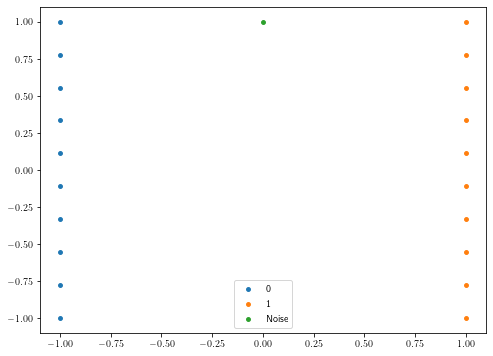

In [46]:
fig = visualize("../experiments/simpler_sanity_experiment_tanimoto/OUT")
fig.savefig("../experiments/simpler_sanity_tanimoto.pdf", bbox_inches='tight')

Num multiple border points: 0


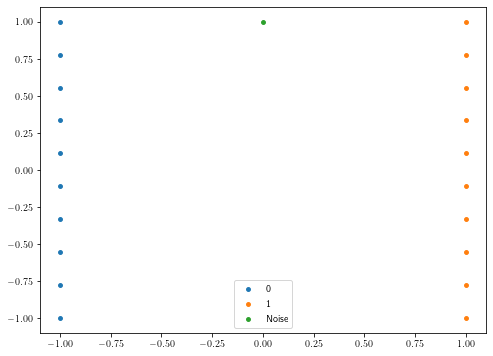

In [47]:
fig = visualize("../experiments/simpler_sanity_experiment_base/OUT")
fig.savefig("../experiments/simpler_sanity_base.pdf", bbox_inches='tight')

Num multiple border points: 6


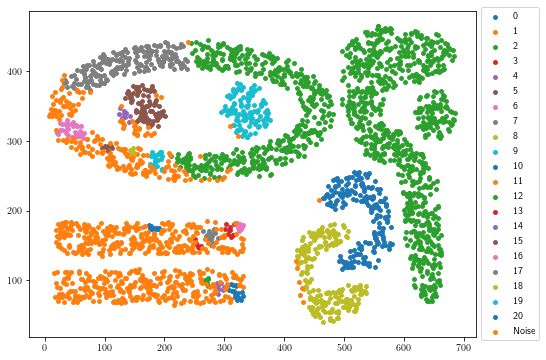

In [23]:
fig = visualize("../experiments/complex9_0.999_10_tanimoto_0_none/OUT", legend=False)
fig.legend(bbox_to_anchor=(0.9, 0.9), loc='upper left')
fig.savefig("../experiments/complex9.pdf", bbox_inches='tight')

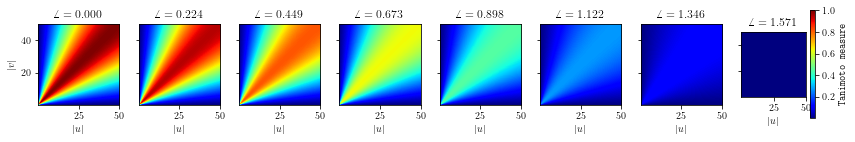

In [24]:
max_value = 50
pixels = 512

def visualize_tanimoto(num: int = 10):
    values_range = np.linspace(0.001, max_value, num=pixels)
    fig, ax = plt.subplots(1, num, sharey=True, figsize=(num * 1.5, 2))
    u_lengths, v_lengths = np.meshgrid(
        values_range, values_range
    )
    
    dots = u_lengths * v_lengths
    measure = dots / (u_lengths ** 2 + v_lengths ** 2 - dots)
    
    v_min = measure.min()
    v_max = measure.max()
    
    for i, angle in enumerate(np.linspace(0.0, math.pi / 2, num=num)):
        dots = u_lengths * v_lengths * np.cos(angle)
        measure = dots / (u_lengths ** 2 + v_lengths ** 2 - dots)
        im = ax[i].imshow(
            measure, 
            cmap=cm.jet,
            vmin=v_min, 
            vmax=v_max,
            extent=[0.001, max_value, 0.001, max_value],
            origin="lower",
        )
        ax[i].set_title(r"$\angle = {:.3f}$".format(angle))
        ax[i].set_xlabel(r"$|u|$")
        if i == 0:
            ax[i].set_ylabel(r"$|v|$")
            
        if i == num - 1:
            cb = fig.colorbar(im, ax=ax[i])
            cb.set_label(r"$\texttt{Tanimoto measure}$")
    
    fig.tight_layout()
    return fig

fig = visualize_tanimoto(8)
fig.savefig("../experiments/tanimoto.pdf", bbox_inches='tight', dpi=200)

In [26]:
final_folders = [
    "cluto-t7-10k_0.99_100_tanimoto_0_none",
    "complex9_0.99_100_tanimoto_0_none",
    "letter_0.99_25_tanimoto_0_none",
]
final_data = []
for file in tqdm.tqdm(files):
    if file.parent.name not in final_folders or "realdata" in file.parent.name and "zpndata" in file.parent.name:
        continue
    with open(file) as f:
        dataset, eps, min_pts, algo, _, filtering = file.parent.name.split("_")
        
        sample = yaml.safe_load(f.read().replace("\t", ""))
        
        if "-model_fitting" in sample:
            sample.update({
                "dataset": dataset if "cluto" not in dataset else "cluto",
                "algorithm": algo,
                "filtering": filtering,
                "model_fitting": sample["-model_fitting"],
                "data_reading": sample["-data_reading"],
                "davis_bouldin": float(sample["davis_bouldin"]),
            })
        else:
            sample.update({
                "dataset": dataset if "cluto" not in dataset else "cluto",
                "algorithm": algo,
                "filtering": filtering,
                "model_fitting": sample["-clustering"],
                "data_reading": sample["-data_reading"],
                "sorting": sample["-sorting"],
                "davis_bouldin": float(sample["davis_bouldin"]),
            })
        
        
        class_assignments = get_class_assignments(file.parent / "OUT")
        total_border_points = seq(class_assignments).filter(lambda x: len(x) > 1).map(len).sum()
        
        sample["\#Multi Borders"] = total_border_points
        
        if "-clustering" in sample:
            del sample["-sorting"]
            del sample["-clustering"]
        else:
            del sample["-model_fitting"]
        
        
        del sample["-data_reading"]
        del sample["runtimes_miliseconds"]
        del sample["input_file"]
        final_data.append(sample)
        
        
        
final_frame = pd.DataFrame(final_data)
final_frame = final_frame.rename(
    columns={
        'purity': 'Purity',
        "davis_bouldin": "Davis-Bouldin",
        "rand": "RAND",
        "silhouette": "Silhouette"
    }
)
final_frame = final_frame.fillna(0)

In [27]:
final_frame

,Eps,minPts,total_runtime_miliseconds,num_discovered_clusters,nun_discovered_core_points,nun_discovered_border_points,num_discovered_noise_points,avg_num_calculations_of_similarity,avg_num_cluster_assignments,num_true_positives,...,Purity,RAND,Silhouette,Davis-Bouldin,dataset,algorithm,filtering,model_fitting,data_reading,\#Multi Borders
0,0.9900,25,66664,69,1864,2511,15625,20000,1.0013,5060527,...,0.2397,0.4007,0.8619,0.7850,letter,tanimoto,none,66616,48,52
1,0.9900,100,9183,3,8359,519,1122,10000,1.0013,7529422,...,0.3945,0.5131,0.2566,0.5696,cluto,tanimoto,none,9172,11,26
2,0.9900,100,762,4,1245,727,1059,3031,1.0096,601659,...,0.4507,0.6238,0.6028,0.4380,complex9,tanimoto,none,759,3,58


### Final results

In [28]:
def print_final_results():
    data = final_frame
    data = data.sort_values(by="dataset")[
        ["dataset", "minPts", "Eps"] + metrics_columns + ["model_fitting", "avg_num_calculations_of_similarity"]
    ]
    max_values = data.max()
    print(len(data))
    for column in data.columns[1:]:
        data[column] = data[column].apply(
            lambda x: "{:.4f}".format(x)
        )
    print(data.to_latex(escape=False, index=False))
print_final_results()

3
\begin{tabular}{llllllllll}
\toprule
 dataset & minPts &  Eps & Purity &   RAND & Silhouette & Davis-Bouldin & \#Multi Borders & model_fitting & avg_num_calculations_of_similarity \\
\midrule
   cluto &  100.0 & 0.99 & 0.3945 & 0.5131 &     0.2566 &        0.5696 &            26.0 &        9172.0 &                            10000.0 \\
complex9 &  100.0 & 0.99 & 0.4507 & 0.6238 &     0.6028 &        0.4380 &            58.0 &         759.0 &                             3031.0 \\
  letter &   25.0 & 0.99 & 0.2397 & 0.4007 &     0.8619 &        0.7850 &            52.0 &       66616.0 &                            20000.0 \\
\bottomrule
\end{tabular}



In [29]:
final_folders

['cluto-t7-10k_0.99_100_tanimoto_0_none',
 'complex9_0.99_100_tanimoto_0_none',
 'letter_0.99_25_tanimoto_0_none']

### Without prefiltering

Num multiple border points: 26


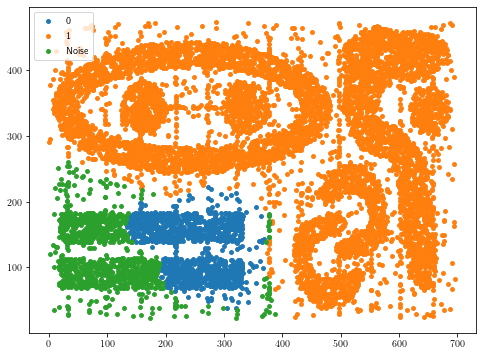

In [30]:
fig = visualize(f"../experiments/{final_folders[0]}/OUT")
fig.savefig("../experiments/final_cluto_none.pdf", bbox_inches='tight')

Num multiple border points: 58


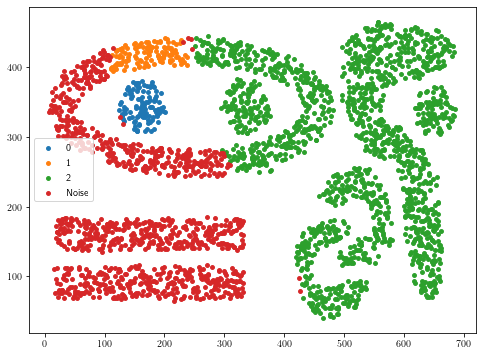

In [31]:
fig = visualize(f"../experiments/{final_folders[1]}/OUT")
fig.savefig("../experiments/final_complex9_none.pdf", bbox_inches='tight')

### With prefiltering

Num multiple border points: 26


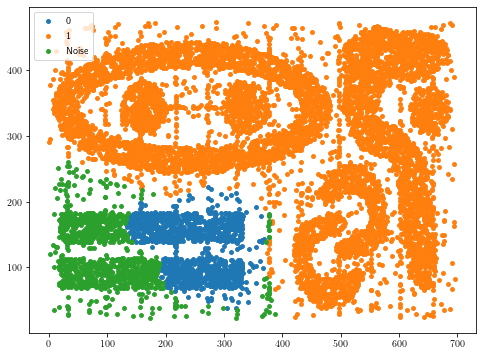

In [32]:
fig = visualize(f"../experiments/{final_folders[0].replace('none', 'real')}/OUT")
fig.savefig("../experiments/final_cluto_real.pdf", bbox_inches='tight')

Num multiple border points: 58


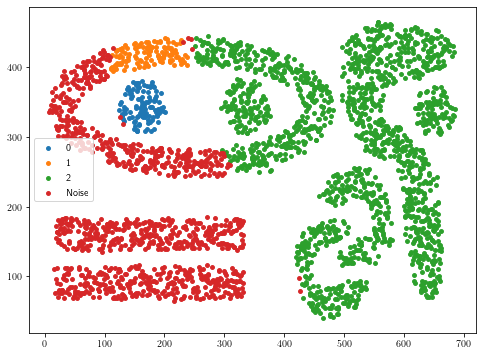

In [33]:
fig = visualize(f"../experiments/{final_folders[1].replace('none', 'real')}/OUT")
fig.savefig("../experiments/final_complex9_real.pdf", bbox_inches='tight')

## Speed comparison

In [34]:
timing_data = []
for file in tqdm.tqdm(files):
    if  "realdata" not in file.parent.name and "zpndata" not in file.parent.name:
        continue
    with open(file) as f:
        dataset, eps, min_pts, algo, _, filtering, data_type = file.parent.name.split("_")
        
        sample = yaml.safe_load(f.read().replace("\t", ""))
        if "-model_fitting" in sample:
            sample.update({
                "dataset": dataset if "cluto" not in dataset else "cluto",
                "algorithm": algo,
                "filtering": filtering,
                "model_fitting": sample["-model_fitting"],
                "data_reading": sample["-data_reading"],
                "davis_bouldin": float(sample["davis_bouldin"]),
            })
        else:
            sample.update({
                "dataset": dataset if "cluto" not in dataset else "cluto",
                "algorithm": algo,
                "filtering": filtering,
                "model_fitting": sample["-clustering"],
                "data_reading": sample["-data_reading"],
                "sorting": sample["-sorting"],
                "davis_bouldin": float(sample["davis_bouldin"]),
            })
        
        class_assignments = get_class_assignments(file.parent / "OUT")
        total_border_points = seq(class_assignments).filter(lambda x: len(x) > 1).map(len).sum()
        
        sample["\#Multi Borders"] = total_border_points
        sample["data_type"] = data_type
        
        
        del sample["-data_reading"]
        
        if "-clustering" in sample:
            del sample["-sorting"]
            del sample["-clustering"]
        else:
            del sample["-model_fitting"]
        
        del sample["runtimes_miliseconds"]
        del sample["input_file"]
        timing_data.append(sample)
        
        
timing_frame = pd.DataFrame(timing_data)
timing_frame = timing_frame.rename(
    columns={
        'purity': 'Purity',
        "davis_bouldin": "Davis-Bouldin",
        "rand": "RAND",
        "silhouette": "Silhouette"
    }
)
timing_frame = timing_frame.fillna(0)

## Num comparisons for real and zpn data

In [35]:
def print_avg_num_calculations_for_datasets_for_epsilon_for_datatype(data_type):
    data = timing_frame[
        (timing_frame["algorithm"] == "tanimoto")
        & (timing_frame["minPts"] == 5)
        & (timing_frame["data_type"] == data_type)
    ][["avg_num_calculations_of_similarity", "filtering", "dataset", "Eps"]]
    
    datasets = ["cluto", "complex9", "letter"]
    
    if data_type == "realdata":
        filtering = ["none", "real"]
    else:
        filtering = ["none", "real", "zpn"]
    out = None
    for d in datasets:
        for f in filtering:
            snippet = data[(data["filtering"] == f) & (data["dataset"] == d)][["Eps", "avg_num_calculations_of_similarity"]]
            snippet = snippet.rename(columns={
                "avg_num_calculations_of_similarity": "avg_{}_{}".format(f, d)
            })
            if out is None:
                out = snippet
                
                print(out.columns)
            else:
                out = pd.merge(
                    out,
                    snippet,
                    on="Eps"
                )
    data = out
    data = data.sort_values(by="Eps")[
        ["Eps"] + [
            "avg_{}_{}".format(f, d) for d in datasets for f in filtering
        ]
    ]
    min_values = data.min()
    for column in data.columns[1:]:
        data[column] = data[column].apply(
            lambda x: "\textbf{{{:d}}}".format(int(x)) if (x == min_values[column] and "none" not in column) else "{:d}".format(int(x))
        )
    print(data.to_latex(escape=False, index=False))
print_avg_num_calculations_for_datasets_for_epsilon_for_datatype("realdata")

Index(['Eps', 'avg_none_cluto'], dtype='object')
\begin{tabular}{rllllll}
\toprule
   Eps & avg_none_cluto & avg_real_cluto & avg_none_complex9 & avg_real_complex9 & avg_none_letter & avg_real_letter \\
\midrule
0.0001 &          10000 &           9999 &              3031 &              3030 &           20000 &           19999 \\
0.0010 &          10000 &           9999 &              3031 &              3030 &           20000 &           19999 \\
0.0100 &          10000 &           9999 &              3031 &              3030 &           20000 &           19999 \\
0.0500 &          10000 &           9998 &              3031 &              3030 &           20000 &           19999 \\
0.1000 &          10000 &           9992 &              3031 &              3030 &           20000 &           19999 \\
0.1500 &          10000 &           9962 &              3031 &              3020 &           20000 &           19999 \\
0.2000 &          10000 &           9866 &              3031 &      

In [36]:
print_avg_num_calculations_for_datasets_for_epsilon_for_datatype("zpndata")

Index(['Eps', 'avg_none_cluto'], dtype='object')
\begin{tabular}{rlllllllll}
\toprule
   Eps & avg_none_cluto & avg_real_cluto & avg_zpn_cluto & avg_none_complex9 & avg_real_complex9 & avg_zpn_complex9 & avg_none_letter & avg_real_letter & avg_zpn_letter \\
\midrule
0.0001 &          10000 &           6914 &          6914 &              3031 &              2087 &             2087 &           20000 &           19957 &          19957 \\
0.0010 &          10000 &           6914 &          6914 &              3031 &              2087 &             2087 &           20000 &           19957 &          19957 \\
0.0100 &          10000 &           6914 &          6914 &              3031 &              2087 &             2087 &           20000 &           19957 &          19957 \\
0.0500 &          10000 &           6914 &          6914 &              3031 &              2087 &             2087 &           20000 &           19957 &          19957 \\
0.1000 &          10000 &           6914 &   

## Time for real and zpn data

In [37]:
def print_time_for_datasets_for_epsilon_for_datatype(data_type):
    data = timing_frame[
        (timing_frame["algorithm"] == "tanimoto")
        & (timing_frame["minPts"] == 5)
        & (timing_frame["data_type"] == data_type)
    ][["model_fitting", "filtering", "dataset", "Eps"]]
    
    datasets = ["cluto", "complex9", "letter"]
    if data_type == "realdata":
        filtering = ["none", "real"]
    else:
        filtering = ["none", "real", "zpn"]
    out = None
    for d in datasets:
        for f in filtering:
            snippet = data[(data["filtering"] == f) & (data["dataset"] == d)][["Eps", "model_fitting"]]
            snippet = snippet.rename(columns={
                "model_fitting": "time_{}_{}".format(f, d)
            })
            if out is None:
                out = snippet
                
                print(out.columns)
            else:
                out = pd.merge(
                    out,
                    snippet,
                    on="Eps"
                )
    data = out
    data = data.sort_values(by="Eps")[
        ["Eps"] + [
            "time_{}_{}".format(f, d) for d in datasets for f in filtering
        ]
    ]
    min_values = data.min()
    print(len(data))
    for column in data.columns[1:]:
        data[column] = data[column].apply(
            lambda x: "\textbf{{{:d}}}".format(int(x)) if (x == min_values[column] and "none" not in column) else "{:d}".format(int(x))
        )
    print(data.to_latex(escape=False, index=False))
print_time_for_datasets_for_epsilon_for_datatype("realdata")

Index(['Eps', 'time_none_cluto'], dtype='object')
28
\begin{tabular}{rllllll}
\toprule
   Eps & time_none_cluto & time_real_cluto & time_none_complex9 & time_real_complex9 & time_none_letter & time_real_letter \\
\midrule
0.0001 &           10418 &           10525 &                847 &                865 &            69511 &            70783 \\
0.0010 &           10556 &           10543 &                844 &                865 &            68883 &            70304 \\
0.0100 &           10498 &           10555 &                834 &                865 &            69869 &            70538 \\
0.0500 &           10684 &           10798 &                850 &                866 &            68832 &            70343 \\
0.1000 &           10493 &           10674 &                846 &                867 &            68874 &            70681 \\
0.1500 &           10513 &           10623 &                843 &                865 &            68895 &            71991 \\
0.2000 &           104

In [38]:
print_time_for_datasets_for_epsilon_for_datatype("zpndata")

Index(['Eps', 'time_none_cluto'], dtype='object')
28
\begin{tabular}{rlllllllll}
\toprule
   Eps & time_none_cluto & time_real_cluto & time_zpn_cluto & time_none_complex9 & time_real_complex9 & time_zpn_complex9 & time_none_letter & time_real_letter & time_zpn_letter \\
\midrule
0.0001 &            9239 &            6623 &           6600 &                798 &                564 &               568 &            66544 &            66839 &           66445 \\
0.0010 &            9518 &            6629 &           7001 &                789 &                560 &               570 &            68117 &            67381 &           67468 \\
0.0100 &            9143 &            6600 &           6618 &                785 &                570 &               570 &            66811 &            66463 &           66324 \\
0.0500 &            9122 &            6621 &           6583 &                796 &                567 &               566 &            67034 &            66597 &           66219